<font size=5>
  Manuel Weitzman 201473501-4 --- Andrés Huerta 201473544-8
  </font>

In [0]:
#csv desde drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed, Input, Bidirectional
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization, InputLayer
from keras.layers import RepeatVector
from keras.models import Sequential
from keras.layers import Embedding,CuDNNGRU
from keras.layers import GRU, TimeDistributed,Dense

Using TensorFlow backend.


## 3. *Encoder-Decoder* sobre Texto

Trabajos recientes en redes neuronales han demostrado que se puede aplicar a problemas bastante complejos gracias a la flexibilidad la definición de las redes, además de que se pueden adaptar a distintos tipos de datos brutos (dominios). Con el objetivo de explorar el enfoque anterior de *traducción* de algun tipo de dato, en esta sección deberá realizarlo con texto para traducción de un lenguaje humano a otro (e.g. inglés a alemán, chino a ruso).

In [0]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/por.txt", sep="\t", names=["Source","Target"])

> a) Visualice los datos ¿Qué es la entrada y qué es la salida? Comente sobre los múltiples significados/sinónimos que puede tener una palabra al ser traducida y cómo propondría arreglar eso. *se espera que pueda implementarlo*

In [0]:
print("Cantidad de ejemplos:",len(df))

Cantidad de ejemplos: 135671


Se cuenta con un total de 135671 ejemplos para preparar y probar la red neuronal, a diferencia de otros conjuntos no hay una deficiencia de casos por lo que no deberia ser necesario implementar data augmentation

In [0]:
df.head(10)

,Source,Target
0,Go.,Vai.
1,Go.,Vá.
2,Hi.,Oi.
3,Run!,Corre!
4,Run!,Corra!
5,Run!,Corram!
6,Run.,Corre!
7,Run.,Corra!
8,Run.,Corram!
9,Who?,Quem?


La entrada del dataset corresponde a la frase o palabra escrita en ingles y el objetivo o salida corresponde a la traducción de lo anterior al idioma que se desea trabajar, en este caso portugues.

Al inicio del dataset se pueden ver unicamente palabras junto con su traducción explicita, se puede notar ademas que existen palabras repetidas en ingles que se traducen de una manera distinta, esto se debe a que el ingles no posee una conjugación explicita en la palabra como es el caso del español o el portuges, sino que se le da un contexto con el resto de la oración. Se espera que la red tenga problemas al traducir frases con dichas palabras.

In [0]:
df.tail()

,Source,Target
135666,"The Tatoeba Project, which can be found online...","O Projeto Tatoeba, que se pode encontrar on-li..."
135667,No matter how much you try to convince people ...,Não importa o quanto você tenta convencer os o...
135668,Some movies make such an impact that one never...,Alguns filmes são tão marcantes que jamais nos...
135669,A child who is a native speaker usually knows ...,Uma criança que é falante nativa geralmente sa...
135670,We recommend adding sentences and translations...,Recomendamos acrescentar frases e traduções na...


Cuando se analizan los datos al final del conjunto se puede ver que ya se esta trabajando con oraciones y no unicamente con palabras simples, se espera que estos ejemplos permitan a la red neuronal aprender a reconocer un poco el contexto en el cual se esta utilizando la palabra.

> b) Realice un pre-procesamiento a los textos como se acostumbra para eliminar símbolos inecesarios u otras cosas que estime conveniente, comente sobre la importancia de éste paso. Además de ésto deberá agregar un símbolo al final de la sentencia *target* para indicar un "alto" cuando la red neuronal necesite aprender a generar una sentencia.

In [0]:
table = str.maketrans('', '', string.punctuation)

def clean_text(text, where=None):
    """ OJO: Sin eliminar el significado de las palabras."""
    text = text.lower()
    tokenize_text = text.split()
    tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
    tokenize_text = [word for word in tokenize_text if word.isalpha()] #remove numbers
    if where == 'target':
        tokenize_text = tokenize_text + ["<EOS>"] 
    return tokenize_text

  
texts_input = list(df['Source'].apply(clean_text))
texts_output = list(df['Target'].apply(clean_text, where='target'))

> Cree un conjunto de validación y de pruebas fijos de $N_{exp} = 10000$ datos ¿Cuántos datos quedan para entrenar? 

In [0]:
N_exp = 10000

In [0]:
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output, test_size=N_exp, random_state=22)

X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, test_size=N_exp, random_state=22)

In [0]:
print("Ejemplos disponibles para entrenar:",len(X_train_l))

Ejemplos disponibles para entrenar: 115671


Luego de haber generado el cconjunto de testing y validación aún quedan 115671 ejemplos para entrenar el modelo.

> *Recuerde que si no puede procesar los datos de entrenamiento adecuadamente siempre puede muestrear en base a la capacidad de cómputo que posea*

> c) Genere un vocabulario, **desde el conjunto de entrenamiento**, sobre las palabras a recibir y generar en la traducción, esto es codificarlas a un valor entero que servirá para que la red las vea en una representación útil a procesar, *comience desde el 1 debido a que el cero será utilizado más adelante*. Para reducir el vocabulario considere las palabras que aparecen un mínimo de *min_count* veces en todo los datos, se aconseja un valor de 3. Comente sobre la importancia de ésto al reducir el vocabulario .

In [0]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]
  
vocab_source = create_vocab(X_train_l, min_count=3)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=3)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)}  #Converting text to numbers
idx2word_t = {i+1: w for i, w in enumerate(vocab_target)}
n_words_t = len(vocab_target)

> **¿De qué tamaño es el vocabulario de entrada y salida?**

Dado que existe una gran cantidad de palabras dentro del vocabulario y la memoria del sistema que se utilice no es ilimitada es necesario reducir el tamaño para poder trabajar con el dataset, ademas palabras que aparescan menos de una determinada cantidad de veces pueden considerarse como poco relevantes para la traducción del texto.

In [0]:
print("Tamaño de palabras en origen:",n_words_s)
print("\nTamaño de palabras en destino",n_words_t)

Tamaño de palabras en origen: 5954

Tamaño de palabras en destino 8760


El tamaño del conjunto de palabras de origen es de 5954 palabras, mientras que el destino es de 8760, esto se debe a lo comentado anteriormente referenciando a que el ingles obtiene la conjugación de una palabra en base al contexto en el cual se esta hablando y no explicitamente en la forma en que se escribe.

> **¿La diferencia de ésto podría ser un factor importante?**

Se tendería a pensar que si podría ser un factor decisivo en la calidad de un modelo, pero dado que un encoder se encarga de obtener un vector de contexto podría darse que se logra encontrar las asociaciones que tienen las palabras dependiendo de como se utilicen, probablemente no se alcance una calidad muy alta, pero por lo menos podría darse una aproximación de las traducciones.

> Ahora codifique las palabras a los números indexados con el vocabulario. Recuerde que si una palabra en los otros conjuntos, o en el mismo de entrenamiento, no aparece en el vocabulario no se podrá generar una codificación, por lo que será **ignorada** ¿Cómo se podría evitar ésto?

Se podría evitar disminuyendo la cantidad de palabras necesarias para pertenecer al vocabulario, otra forma podria ser evitar las frases que utilicen palabras que no pertenecen al vocabulario.

In [0]:
""" Source/input data """
dataX_train = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_train_l]
dataX_val = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_val_l]
dataX_test = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_test_l]

""" Target/output data """
dataY_train = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_train_l]
dataY_val = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_val_l] 
dataY_test = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_test_l] 

> d) Debido al largo variable de los textos de entrada y salida será necesario estandarizar ésto para poder trabajar de manera más cómoda en Keras, *cada texto (entrada y salida) pueden tener distinto largo máximo*. Comente sobre la decisión del tipo de *padding*, *pre o post* ¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)?

In [0]:
""" INPUT DATA (Origin language) """
max_inp_length = max([max(map(len,dataX_train)), max(map(len,dataX_val)), max(map(len,dataX_test))])
print("Largo max inp: ",max_inp_length)
word2idx_s["*"] = 0 #padding symbol
idx2word_s[0] = "*"
n_words_s += 1  
X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='post', value=word2idx_s["*"])
X_val = sequence.pad_sequences(dataX_val, maxlen=max_inp_length, padding='post', value=word2idx_s["*"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='post', value=word2idx_s["*"])

""" OUTPUT DATA (Destination language) """
max_out_length = max([max(map(len,dataY_train)), max(map(len,dataY_val)), max(map(len,dataY_test))])
print("Largo max out: ",max_out_length)
word2idx_t["*"] = 0 #padding symbol
idx2word_t[0] = "*"
n_words_t += 1  
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
Y_val = sequence.pad_sequences(dataY_val, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["*"])


Largo max inp:  35
Largo max out:  34


In [0]:
#import operator

#max(.iteritems(), key=operator.itemgetter(1))[0]

> e) Para evitar que la red obtenga una ganancia por imitar/predecir el símbolo de *padding* que está bastante presente en los datos coloque un peso sobre éste clase, con valor 0, así se evita que tenga impacto en la función objetivo. Ya que *keras* no soporta directamente ésto en series de tiempo coloque el peso a cada instante de tiempo de cada dato de entrenamiento dependiendo de su clase. Comente sobre alguna otra forma en que se podría manejar el evitar que la red prediga en mayoría el símbolo de *padding*.

In [0]:
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]

Otra para evitar que la red tenga un score alto debido a la predicción del padding corresponde a generar una mascara para evitar considerar valores que sean iguales a los determinados en la condición de la mascara.

> f) Para lograr la tarea defina una red recurrente del tipo *encoder*-*decoder* como la que se presenta en la siguiente imágen. En primer lugar defina el *Encoder* que procesara el texto de entrada y retornará un solo vector final, haciendo uso de las capas ya conocidas de *Embedding* para generar un vector denso de palabra y *GRU*, pero en su versión acelerada para GPU.

<img src="https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png" width="60%" />

In [0]:
def plot_losses(hist): 
  plt.figure(figsize=(15, 7))
  
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  
  plt.legend(["Train Loss", "Val Loss"], loc="upper right")
  
  plt.title("Traning & Test Losses")
  
  plt.show()
  
  print("Final Train Loss:",hist.history['loss'][-1])
  print("Min val_loss:",min(hist.history['val_loss']))

In [0]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(CuDNNGRU(128, return_sequences=False))

W0801 20:35:57.161721 140201266190208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 20:35:57.179274 140201266190208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 20:35:57.181794 140201266190208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



> Luego defina la sección que conecta el largo (*timesteps*) de entrada *vs* el de salida.

In [0]:
model.add(RepeatVector(max_out_length)) #conection

> Finalmente defina el *Decoder* para generar la secuencia de salida en texto de palabras en otro idioma, a través de la función *softmax* sobre cada instante de tiempo (*timestep*). 

In [0]:
model.add(CuDNNGRU(128, return_sequences=True))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 100)           595500    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 35, 64)            31872     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 128)               74496     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 34, 128)           0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 34, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 34, 64)            37248     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 34, 8761)          569465    
Total para

> Entrene la red entre 1 a 5 *epochs*, agregando los pesos definidos sobre cada ejemplo de entrenamiento. Además de utilizar una función de pérdida que evita generar explícitamente los *one hot vector*


Antes de entrenar es necesario cambiar la forma del output a 3 dimensiones de modo que se pueda establecer (Cantidad de ejemplos, Timestamps y la clase)

In [0]:
Y_train = np.reshape(Y_train, (Y_train.shape[0], max_out_length, 1)) #Examples, Timestamps, Class
Y_val = np.reshape(Y_val, (Y_val.shape[0], max_out_length, 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], max_out_length, 1))

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
history = model.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=0)

W0801 20:35:58.264205 140201266190208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0801 20:35:58.287893 140201266190208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.

W0801 20:35:58.366923 140201266190208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0801 20:35:58.791640 140201266190208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated

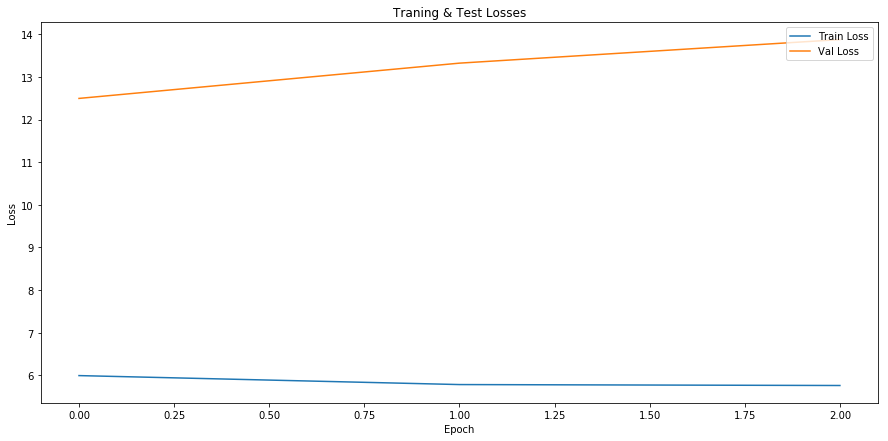

Final Train Loss: 5.758747957356929
Min val_loss: 12.496376498413087


In [0]:
plot_losses(history)

Se puede notar un overfitting al observar la diferencia entre loss del conjunto de entrenamiento y de validación, esto puede deberse a la forma en que se determina si una frase fue traducida correctamente, al ser un etiquetado de multiples clases por frase probablemente el learner determina que al tener una sola palabra mal catalogada la frase en general esta incorrecta.

> g) Debido a lo costoso de tener una red completamente recurrente para entrenar y poder experimentar, cambie el modelo que procesa el *Encoder* por una red convolucional, reduciendo el número de capas pero aumentando las neuronas. Utilice tamaños de *kernel*  igual a 5 y funciones de activaciones relu. Se agregan capas de *BatchNormalization* debido a que en el *Decoder* contamos con redes recurrentes que tienen capa activación distinta a la usada por las convoluciones. La capa de *GlobalMaxPooling1d* es lo que permite reducir toda la información extraída a un único vector, como se realizó anteriormente con *return_sequences=False*, comente sobre la ganancia o desventaja de ésto *vs* la red neuronal.

In [0]:
modelc = Sequential()
modelc.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
modelc.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modelc.add(BatchNormalization()) #for stability
modelc.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modelc.add(BatchNormalization())
modelc.add(GlobalMaxPooling1D()) #aka to return_sequences=False
modelc.add(RepeatVector(max_out_length)) #conection
modelc.add(CuDNNGRU(256, return_sequences=True))
modelc.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
modelc.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
modelc.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 100)           595500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 256)           128256    
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 256)           1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 256)           1024      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 34, 256)           0         
__________

Una red convolucional se caracteriza por extraer caracteristicas importantes utilizando una menor cantidad de parámetros entrenables, esto es lo que nos permite aumentar la cantidad de neuronas ha utilizar sin perjudicar en gran medida el tiempo de entrenamiento.

> Entrene el modelo igual a lo presentado anteriormente pero ahora por 20 *epochs* ¿Cambian los tiempos de procesamiento y la cantidad de parámetros?

In [0]:
historyc = modelc.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=0)

El tiempo de procesamiento se mantiene casi a la par con el encoder recurrente a pesar de tener una mayor cantidad de neuronas y parámetros entrenables.

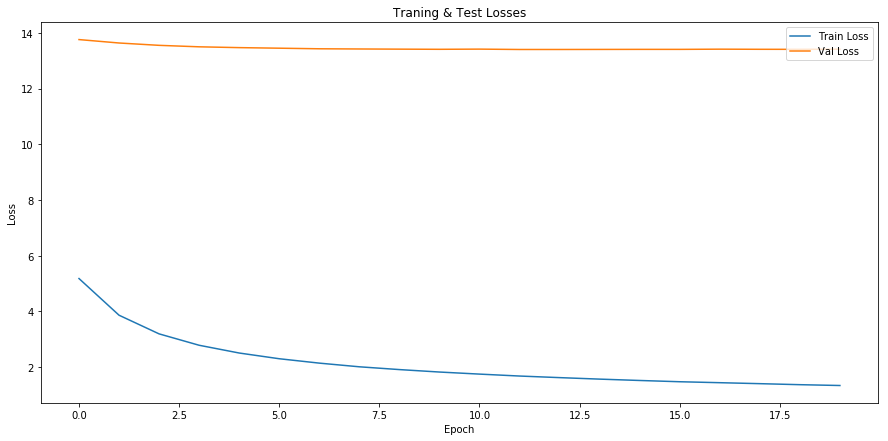

Final Train Loss: 1.344768019416162
Min val_loss: 13.400520515441894


In [0]:
plot_losses(historyc)

Al igual que el caso anterior, el error de validación tiene el mismo comportamiento, pero se puede ver un mayor ajuste con el conjunto de entrenamiento, ademas de un convergencia mas temprana.

> h) Visualice lo aprendido por el modelo sobre algunos datos del conjunto de entrenamiento y validación, comente lo observado.

In [0]:
def predict_words(y_indexs, data="target"):
    """ Predict until '-#anvorgesa-' is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["<EOS>"]:
                    return return_val                
    return return_val
  
n_s = 5
idx = np.random.choice(np.arange(Y_test.shape[0]), size=n_s, replace=False)

In [0]:
print("For the first model:")
Y_test_pred = model.predict_classes(X_test[idx])
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_test[n_sampled], data="source")]
    print("\nText source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Text target true: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_test_pred[i], data="target")]
    print("Text target predicted: ", ' '.join(text_sampled))

For the first model:

Text source:  ive tried doing it that way already
Text target true:  eu já tentei fazêlo dessa maneira <EOS>
Text target predicted:  <EOS>

Text source:  thats how we dealt with it
Text target true:  foi assim que com isso <EOS>
Text target predicted:  <EOS>

Text source:  we have to change our plan
Text target true:  temos de mudar nosso plano <EOS>
Text target predicted:  <EOS>

Text source:  the students were told to learn the poem by heart
Text target true:  disseram aos estudantes que o poema de cor <EOS>
Text target predicted:  <EOS>

Text source:  the robber the bag from his hand
Text target true:  o ladrão pegou a bolsa da sua mão <EOS>
Text target predicted:  <EOS>


En el caso del encoder con una red recurrente se obtiene un mal desempeño en el cual independiente de la frase que se quiera predecir devuelve "tom que" o "eu tom" dependiendo de la ejecución que se realice, observando algunas de las frases del conjunto de pruebas se ve que existe una gran cantidad de oraciones donde se utiliza la palabra "tom" por lo que podría generalizar de manera que muestre la mayor cantidad de veces dicha palabra.

In [0]:
print("For the convolutional model:")
Y_test_pred = modelc.predict_classes(X_test[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_test[n_sampled], data="source")]
    print("\nText source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Text target true: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_test_pred[i], data="target")]
    print("Text target predicted: ", ' '.join(text_sampled))

For the convolutional model:

Text source:  ive tried doing it that way already
Text target true:  eu já tentei fazêlo dessa maneira <EOS>
Text target predicted:  tentei tentei fazêlo dessa maneira <EOS>

Text source:  thats how we dealt with it
Text target true:  foi assim que com isso <EOS>
Text target predicted:  é improvável que nós isso <EOS>

Text source:  we have to change our plan
Text target true:  temos de mudar nosso plano <EOS>
Text target predicted:  temos de mudar nosso plano <EOS>

Text source:  the students were told to learn the poem by heart
Text target true:  disseram aos estudantes que o poema de cor <EOS>
Text target predicted:  os alunos alunos ao para que se se de <EOS>

Text source:  the robber the bag from his hand
Text target true:  o ladrão pegou a bolsa da sua mão <EOS>
Text target predicted:  o o a sua mão mão mão <EOS>


Para el caso del encoder que utiliza una red convolucional se puede ver una clara mejora en la forma en que la red traduce las palabras, en donde para los ejemplos observados se ve que devuelve las palabra necesarias para traducir, pero tiende a repetir en algunos casos mas de una vez una palabra. Para este caso una red convolucional logra generar un mejor vector de contexto para el decoder, la red recurrente utilizada podría ser mejorada por medio de modificaciones a su arquitectura a cambio de un mayor tiempo de ejecución (por ejemplo aplicar bidireccionalidad)

> i) Realice algún cambio esperando que mejore el modelo entrenado, luego vuelva a visualizar lo predicho por la red *vs* lo real. *Debido a lo costoso en entrenar puede optar por realizar solo un cambio pero que sea significativo*.  Se comentan algunas opciones para utilizar y combinar:
* Cambiar  el *embedding* por alguno pre-entrenado
* Agregar regularizadores
* Asignar peso a las clases/palabras de salida
* Cambiar *Global max pooling* por *Average max pooling*
* Aumentar o reducir capas
* Aumentar o reducir neuronas/unidades  

Se pre entrena un embedding con los textos pertenecientes a glove con 200 dimensiones.

In [0]:
embeddings_index2 = dict()
EMBEDDING_DIM2 = 200

f = open('drive/My Drive/glove.6B.'+str(EMBEDDING_DIM2)+'d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index2[word] = coefs
f.close()

In [0]:
embedding_matrix2 = np.zeros((n_words_s, EMBEDDING_DIM2))
for word, i in word2idx_s.items():
    embedding_vector = embeddings_index2.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix2[i] = embedding_vector

Ademas, se permite al Embedding el reajuste de pesos de acuerdo al conjunto de entrenamiento por el desempeño encontrado en actividades anteriores. Para el decoder se permite la bidireccionalidad de las secuencias con un merge mode en concatenación para no perder información importante.

In [0]:
modeli = Sequential()
modeli.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM2, input_length=max_inp_length, trainable=True, weights = [embedding_matrix2]))
modeli.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modeli.add(BatchNormalization()) #for stability
modeli.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modeli.add(BatchNormalization())
modeli.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
modeli.add(BatchNormalization())
modeli.add(GlobalMaxPooling1D()) #aka to return_sequences=False
modeli.add(RepeatVector(max_out_length)) #conection
gate_layer = CuDNNGRU(256, return_sequences=True)
modeli.add(Bidirectional(gate_layer, merge_mode='concat'))
modeli.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
modeli.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
modeli.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 200)           1191000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 256)           256256    
_________________________________________________________________
batch_normalization_3 (Batch (None, 35, 256)           1024      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
batch_normalization_4 (Batch (None, 35, 256)           1024      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
batch_normalization_5 (Batch (None, 35, 256)           1024      
__________

Se puede notar un gran aumento en la cantidad de parámetros entrenables con respecto a la red convolucional entrenada anteriormente (al rededor de 2 millones de pesos).

In [0]:
historyi = modeli.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=0)

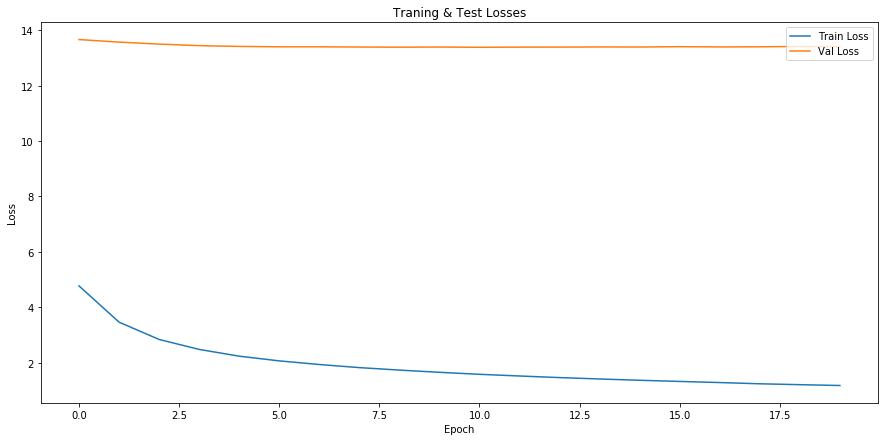

Final Train Loss: 1.17761820682784
Min val_loss: 13.383806513977051


In [0]:
plot_losses(historyi)

Se observa el mismo comportamiento para el conjunto de validación de los observados anteriormente.

In [0]:
print("For the convolutional model:")
Y_test_pred = modeli.predict_classes(X_test[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_test[n_sampled], data="source")]
    print("\nText source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Text target true: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_test_pred[i], data="target")]
    print("Text target predicted: ", ' '.join(text_sampled))

For the convolutional model:

Text source:  ive tried doing it that way already
Text target true:  eu já tentei fazêlo dessa maneira <EOS>
Text target predicted:  já tentei fazêlo isso dessa <EOS>

Text source:  thats how we dealt with it
Text target true:  foi assim que com isso <EOS>
Text target predicted:  é isso que nós <EOS>

Text source:  we have to change our plan
Text target true:  temos de mudar nosso plano <EOS>
Text target predicted:  temos que mudar nosso plano <EOS>

Text source:  the students were told to learn the poem by heart
Text target true:  disseram aos estudantes que o poema de cor <EOS>
Text target predicted:  a alunos que que a o o o de <EOS>

Text source:  the robber the bag from his hand
Text target true:  o ladrão pegou a bolsa da sua mão <EOS>
Text target predicted:  o homem pegou a sua mão sua mão <EOS>


Los resultados de la red son similares a los de la red convolucional anteriormente utilizada, un detalle a destacar corresponde a que la red no puede detectar los significados implicitos dentro de las palabras como el caso de "im not famous", la traducción literal corresponde a "Yo no soy famoso" el cual es lo que la red devuelve, pero el verdadero resultado es "No soy famoso"

> j) A pesar de que la tarea de medir qué tan similar es un texto a otro ya es un área de investigación propia [[6]](#refs), usted deberá utilizar alguna métrica de desempeño para ver qué tan buena es la traducción del texto *versus* el texto real entregado. Debido a que la métrica de *Exact Matching* (EM) puede ser muy drástica, mida *f1 score* por texto además de proponer alguna otra técnica de evaluación para medir sobre el conjunto de pruebas y los otros conjuntos si estima conveniente. Puede basarse en otros trabajos como *Image captioning* o *Text summary*. 

> *Hint: Debido a los problemas de memoria al realizar un forward-pass, solo seleccione un subconjunto $N_{sub}$ del conjunto de pruebas para realizar ésta evaluación, se aconseja entre 1000 y 5000.*

In [0]:
m = MultiLabelBinarizer().fit([np.arange(n_words_t)])

def calculate_f1(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])[0] #onehot of words appear
    binarized_pred = m.transform([predict_words(pred)])[0] #onehot of words appear
    return f1_score(binarized_true, binarized_pred, average='binary') #only on appearing words
  
ids = np.random.choice(np.arange(Y_test.shape[0]), size=3000, replace=False)

def evaluate_it_f1(ids, model_temp, X_temp, normal=True):
  Y_true = [Y_test[i] for i in ids]
  if normal == True:
    x_t = np.asarray([X_temp[i] for i in ids])
    Y_hat = model_temp.predict_classes(x_t)
  else:
    Y_hat = model_temp.predict_classes(X_temp[ids])
  

  f1_final = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_true,Y_hat)])
  return f1_final #porcentaje

In [0]:
f1_model = evaluate_it_f1(ids, model, X_test)
f1_modelc = evaluate_it_f1(ids, modelc, X_test)
f1_modeli = evaluate_it_f1(ids, modeli, X_test)

In [0]:
print("F1 score model original:",f1_model)
print("F1 score model convolutional:",f1_modelc)
print("F1 score model modified:",f1_modeli)

F1 score model original: 0.2852709662742945
F1 score model convolutional: 0.7044199795821787
F1 score model modified: 0.7123054236217211


Como se podía esperar desde el primer entrenamiento y visualización de resultados, la primera red obtiene un desempeño muy bajo en comparación a los que utilizan convoluciones en el encoding con un f1_score de 0,7.

> La función de *f1 score* en este extracto se calcula en base al *precision* y *recall* de que aparezca cada una de las palabras predichas dentro de las palabras reales (como si cada palabra fuera una clase de "aparece" o no), **sin importar el orden ni la ocurrencia**.

> k) En vez de volver a variar el modelo de *Encoder*, dejaremos una representación manual explícita (*no entrenable*) a través de extraer características manuales de los textos *source*, como por ejemplo representaciones *term frequency* (TF) o TF-IDF, proporcionadas a través de __[sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)__. Luego, con esto generado, defina y entrene el modelo *Decoder* neuronal como el presentado en las preguntas anteriores, ésto es comenzar desde la capa *RepeatVector* hasta llegar a la clasificación sobre el texto *target*. Compare el desempeño con lo presentado en (j) y lo visualizado en (h).

In [0]:
def dummy_fun(doc):
    return doc
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,
                         token_pattern=None,use_idf= True, smooth_idf=True, norm='l2', max_features=3000)   
X_train_tfidf = tf_idf.fit_transform(dataX_train).astype('float32').todense()
X_val_tfidf = tf_idf.fit_transform(dataX_val).astype('float32').todense()
X_test_tfidf = tf_idf.fit_transform(dataX_test).astype('float32').todense()


A diferencia de un embedding un vectorizador TF-IDF no otorga pesos basados en la distancias que separan palabras, sino que entrega pesos basados en la ocurrencia de cada una, para efectos del problema se estima que los resultados obtenidos a traves de este método no sean de buena calidad.

In [0]:
X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape

((115671, 3000), (10000, 3000), (10000, 3000))

In [0]:
modelf = Sequential()

modelf.add(InputLayer(input_shape=(X_train_tfidf.shape[1],)))
modelf.add(RepeatVector(max_out_length)) #conection
#modelf.add(Input(shape=(X_train_tfidf.shape[1],), sparse=True))
modelf.add(CuDNNGRU(512, return_sequences=True))
modelf.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
modelf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
modelf.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_4 (RepeatVecto (None, 34, 3000)          0         
_________________________________________________________________
cu_dnngru_7 (CuDNNGRU)       (None, 34, 512)           5397504   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 34, 8761)          4494393   
Total params: 9,891,897
Trainable params: 9,891,897
Non-trainable params: 0
_________________________________________________________________


In [0]:
historyf = modelf.fit(X_train_tfidf, Y_train, epochs=20, batch_size=256,validation_data=(X_val_tfidf, Y_val), sample_weight = sample_weight, verbose=0)

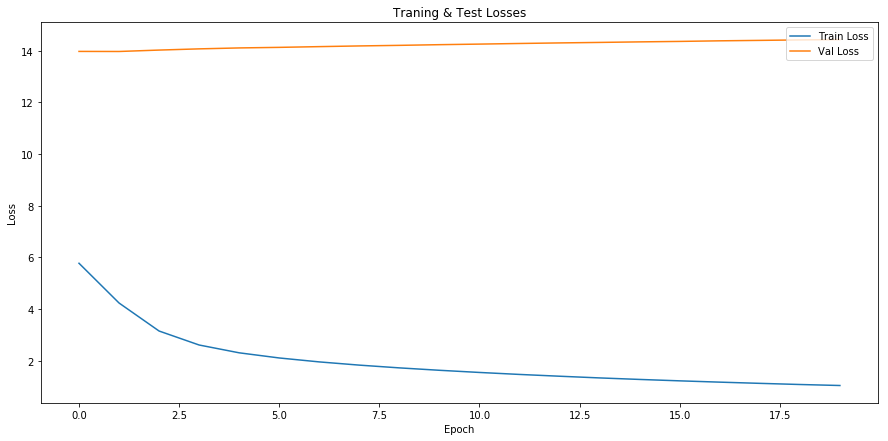

Final Train Loss: 1.0459851383541459
Min val_loss: 13.970270021057129


In [0]:
plot_losses(historyf)

In [0]:
Y_test_pred = modelf.predict_classes(X_test_tfidf[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_test[n_sampled], data="source")]
    print("\nText source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Text target true: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_test_pred[i], data="target")]
    print("Text target predicted: ", ' '.join(text_sampled))


Text source:  ive tried doing it that way already
Text target true:  eu já tentei fazêlo dessa maneira <EOS>
Text target predicted:  assim assim assim em em em <EOS>

Text source:  thats how we dealt with it
Text target true:  foi assim que com isso <EOS>
Text target predicted:  não filme filme a <EOS>

Text source:  we have to change our plan
Text target true:  temos de mudar nosso plano <EOS>
Text target predicted:  não não ser ser ser <EOS>

Text source:  the students were told to learn the poem by heart
Text target true:  disseram aos estudantes que o poema de cor <EOS>
Text target predicted:  a as as as ao uma coleção do <EOS>

Text source:  the robber the bag from his hand
Text target true:  o ladrão pegou a bolsa da sua mão <EOS>
Text target predicted:  a ao máximo do volta ao seu <EOS>


De alguna forma, este método obtiene mejores resultados que la red que utiliza embedding y compuertas gru para generar el vector de contexto, si bien, las oraciones entregadas no se parecen en nada a las originales (por lo menos en los 5 ejemplos observados) se espera que tengan un mejor sentido que "eu tom" o "tom que".

In [0]:
f1_modelf = evaluate_it_f1(ids, modelf, X_test_tfidf, False)

In [0]:
print("F1 score model original:",f1_model)
print("F1 score model convolutional:",f1_modelc)
print("F1 score model modified:",f1_modeli)
print("F1 score model final:",f1_modelf)

F1 score model original: 0.2852709662742945
F1 score model convolutional: 0.7044199795821787
F1 score model modified: 0.7123054236217211
F1 score model final: 0.37294524874029117


La calidad de la ultima red neuronal no supera los resultados de los modelos convolucionales, pero si logra obtener un mejor desempeño que la red original por 0.07.

##Encoding con capas bidireccionales

In [0]:
modele = Sequential()
modele.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM2, input_length=max_inp_length, trainable=True, weights = [embedding_matrix2]))
gate_layer1 = CuDNNGRU(128, return_sequences=False)
modele.add(Bidirectional(gate_layer1, merge_mode='concat'))
modele.add(RepeatVector(max_out_length)) #conection
gate_layer2 = CuDNNGRU(128, return_sequences=True)
modele.add(Bidirectional(gate_layer2, merge_mode='concat'))
modele.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
modele.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
modele.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 35, 200)           1191000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               253440    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 34, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 34, 256)           296448    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 34, 8761)          2251577   
Total params: 3,992,465
Trainable params: 3,992,465
Non-trainable params: 0
_________________________________________________________________


In [0]:
historye = modele.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

Train on 115671 samples, validate on 10000 samples
Epoch 1/20
115671/115671 [==============================] - 55s 479us/step - loss: 5.5783 - val_loss: 13.6128
Epoch 2/20
115671/115671 [==============================] - 53s 462us/step - loss: 4.7652 - val_loss: 13.5171
Epoch 3/20
115671/115671 [==============================] - 54s 465us/step - loss: 4.0012 - val_loss: 13.4905
Epoch 4/20
115671/115671 [==============================] - 54s 466us/step - loss: 3.4545 - val_loss: 13.4909
Epoch 5/20
115671/115671 [==============================] - 54s 468us/step - loss: 3.0522 - val_loss: 13.4672
Epoch 6/20
115671/115671 [==============================] - 54s 469us/step - loss: 2.7507 - val_loss: 13.4571
Epoch 7/20
115671/115671 [==============================] - 54s 469us/step - loss: 2.5227 - val_loss: 13.4489
Epoch 8/20
115671/115671 [==============================] - 54s 469us/step - loss: 2.3472 - val_loss: 13.4342
Epoch 9/20
115671/115671 [==============================] - 54s 469us

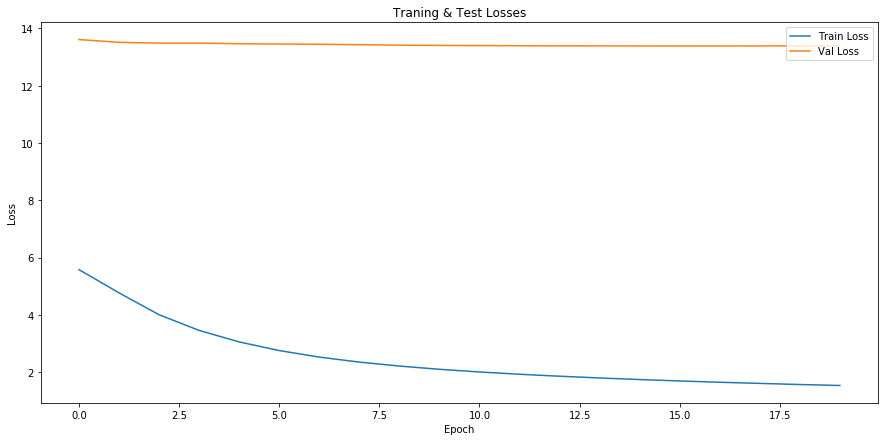

Final Train Loss: 1.53010979017265
Min val_loss: 13.389524981689453


In [0]:
plot_losses(historye)

In [0]:
Y_test_pred = modele.predict_classes(X_test[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_test[n_sampled], data="source")]
    print("\nText source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_test[n_sampled,:,0], data="target")]
    print("Text target true: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_test_pred[i], data="target")]
    print("Text target predicted: ", ' '.join(text_sampled))


Text source:  ive tried doing it that way already
Text target true:  eu já tentei fazêlo dessa maneira <EOS>
Text target predicted:  já tentei tentei isso maneira maneira <EOS>

Text source:  thats how we dealt with it
Text target true:  foi assim que com isso <EOS>
Text target predicted:  isso isso isso isso isso com <EOS>

Text source:  we have to change our plan
Text target true:  temos de mudar nosso plano <EOS>
Text target predicted:  temos temos mudar nosso nosso nosso <EOS>

Text source:  the students were told to learn the poem by heart
Text target true:  disseram aos estudantes que o poema de cor <EOS>
Text target predicted:  os alunos aprenderam a decorar a estudantes os os alunos <EOS>

Text source:  the robber the bag from his hand
Text target true:  o ladrão pegou a bolsa da sua mão <EOS>
Text target predicted:  o assaltante a a mão de de <EOS>


In [0]:
f1_modele = evaluate_it_f1(ids, modele, X_test, True)

In [0]:
print("F1 score model original:",f1_model)
print("F1 score model convolutional:",f1_modelc)
print("F1 score model modified:",f1_modeli)
print("F1 score model final:",f1_modelf)
print("F1 score model extra:",f1_modele)

F1 score model original: 0.2852709662742945
F1 score model convolutional: 0.7044199795821787
F1 score model modified: 0.7123054236217211
F1 score model final: 0.37294524874029117
F1 score model extra: 0.7020198514940754
